In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 

ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, Buck, LennardJones69
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms
from math import sqrt

import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

_ColormakerRegistry()

In [4]:
from sklearn.datasets import make_circles, make_checkerboard, make_moons

In [5]:
x, y = make_circles(n_samples=2014, noise=0.02, factor=0.4)
# x, y = make_moons(n_samples=400,
#                   noise=0.09,
#                   random_state=1)

In [2]:

#plt.figure(figsize=(5,5))
plt.scatter( x[:,0], x[:, 1] )

NameError: name 'plt' is not defined

In [6]:
# initialize a 2d Hamiltonian 
class NHODE(torch.nn.Module):

    def __init__(self, model, mass, target_momentum=4.0, num_chains=2, ttime = 10.0, dt= 0.005, device=0, dim=3,
                 time_dependent=True):
        super().__init__()
        self.model = model  
        self.mass = torch.Tensor(mass).to(device)
        self.time_dependent = time_dependent
    
        self.device = device 
        self.target_momentum = target_momentum
        self.ttime = ttime 
        self.N_dof = mass.shape[0] * dim
        self.target_ke = (0.5 * self.N_dof * self.target_momentum **2 )
        
        self.T = torch.Tensor( [self.target_momentum **2] ).to(device)
        self.num_chains = num_chains
        self.Q = np.array([1,
                   *[1]*(num_chains-1)]) 
        self.Q = torch.Tensor(self.Q).to(device)
        self.dim = dim
        
    def forward(self, t, state):
        # pq are the canonical momentum and position variables
        with torch.set_grad_enabled(True):
            
            N = self.N_dof
            
            pq = state[0]
            
            B = pq.shape[0]
            
            t.requires_grad = True
            pq.requires_grad = True
            t = t.expand(B, 1)
            
            p = pq[:, :N]
            q = pq[:, N:2* N].reshape(-1, self.dim)
            
            sys_ke = 0.5 * (p.reshape(-1, self.dim).pow(2) / self.mass[:, None]).sum(-1) 
            
            # definite all the virtual momentums 
            p_v = pq[:, -self.num_chains:]      
            u = self.model(q, t)
            
            dqdt = (p.reshape(-1, self.dim) / self.mass[:, None])#.reshape(-1)
            dpdt = -compute_grad(inputs=q, output=u).reshape(-1, self.dim) - p_v[:, [0]] * p / self.Q[0]
            
            u_sum = u.sum()
            if self.time_dependent:
                dWdt = compute_grad(inputs=t, output=u_sum) 

            else:
                dWdt = torch.Tensor( [0.0] ).to(self.device) 

            dpvdt_0 = 2 * (sys_ke - self.T * self.N_dof * 0.5) - p_v[:, 0] * p_v[:, 1]/ self.Q[1]
            dpvdt_mid = (p_v[:, :-2].pow(2) / self.Q[:-2] - self.T) - p_v[:, 2:]*p_v[:, 1:-1]/ self.Q[2:]
            dpvdt_last = p_v[:, -2].pow(2) / self.Q[-2] - self.T

        f = torch.cat((dpdt, dqdt, dpvdt_0[:, None], dpvdt_mid, dpvdt_last[:, None]), dim=1)
        dQdt = (-dqdt * dpdt).sum(-1).reshape(-1, 1)
        
        #print(dqdt.shape, dpdt.shape)
        
        #print(f.shape, dWdt.shape, dQdt.shape)
        
        return (f, dWdt, dQdt)

In [559]:
# construct a NN non-equilibrium flow model 
from torch import nn

nlr = nn.ReLU()

# initial model: a NN 
class noneqharm_control(torch.nn.Module):
    def __init__(self, device, tau=100, k_0=1.0):
        super(noneqharm_control, self).__init__()
        self.tau = tau
        self.k_0 = k_0
        self.device = device
        self.net = nn.Sequential(
                                nn.Linear(2, 32), 
                                nlr,
                                nn.Linear(32, 64),
                                nlr,  
                                nn.Linear(64, 32),
                                nlr,
                                nn.Linear(32, 16),
                                nlr,
                                nn.Linear(16, 1)
                               )
        
    def E(self, x):
        return self.net(x) #- self.net(torch.Tensor([0.0]).to(self.device))
    
    def control(self, t): 
        return 1 - (1/self.tau) * t 
    
    def forward(self, x, t):
        #print(self.control(t))
        #print(x.shape)
        #print( self.E(x).shape )
        H1 = (0.5 * self.k_0 * self.control(t) * (x ** 2).sum(-1)[:, None])
        #print(H1.shape, self.control(t).shape, (x ** 2).sum(-1)[:, None].shape) 
        H2 = ((1 - self.control(t)) * self.E(x))#.reshape(-1)
        #print(H2.shape)
        H = H1 + H2 
        #print(self.E(x).shape, (x ** 2).sum(-1).shape)
        #print(H.shape)
        #print(H.shape)
        return H
    
def plot_sep(model, Xdata, ref, device):
    
    #plt.title('lr={} beta={} acc={}'.format(lr, beta, acc))
    plt.figure(figsize=(7,5))
    res=30
    xlist = np.linspace(-1.5, 1.5, res)
    ylist = np.linspace(-1.5, 1.5, res)
    X_mesh, Y_mesh = np.meshgrid(xlist, ylist)
    data = torch.Tensor(np.concatenate((X_mesh[:,:, None],Y_mesh[:,:,None]), axis=2).reshape(-1,2)).to(device)
    output = model(data).detach().cpu().numpy().reshape(res, res)
    cp = plt.contourf(X_mesh, Y_mesh, output, 40,# cmap='Blues',
                      alpha=0.4)
    
    Xdata = Xdata.detach().cpu().numpy()
    ref = ref.detach().cpu().numpy()
    plt.scatter(Xdata[::,0] , Xdata[::,1], alpha=0.3, s=4)
    plt.scatter(ref[::,0] , ref[::,1], alpha=0.3, s=4)
    plt.xlim((-1.1, 1.1))
    plt.ylim((-1.1, 1.1))
    plt.colorbar(cp)
    plt.show()

In [560]:
DEVICE = 0
num_chains = 3
B = 1024
tau = 7.0
dt = 0.1
t_len = int( tau / dt )
dim = 2

In [561]:
h = noneqharm_control(tau=tau, device=DEVICE, k_0=1.0).to(DEVICE)

f_x = NHODE(h, 
            torch.Tensor([1.0]), 
            ttime=50.0, 
            num_chains=num_chains, 
            device=DEVICE,
            target_momentum=1.0,
            time_dependent=True,
            dim=2).to(DEVICE)

In [562]:
optimizer = torch.optim.Adam(list( h.parameters() ), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

-0.527867317199707 7.0


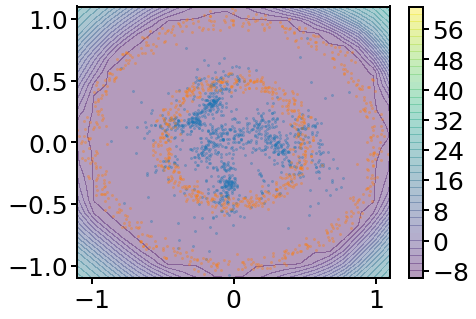

-0.5313129425048828 7.0


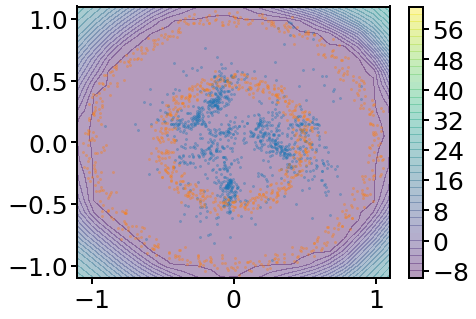

-0.574498176574707 7.0


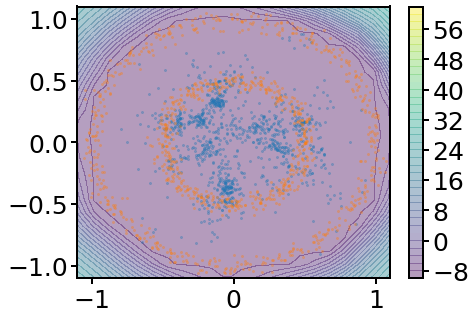

-0.5651025772094727 7.0


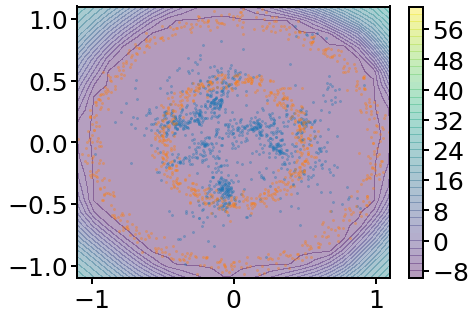

-0.6036515235900879 7.0


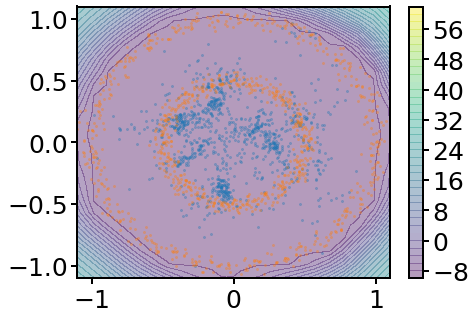

-0.5734457969665527 7.0


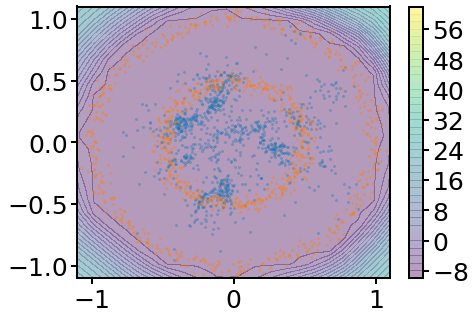

-0.553462028503418 7.0


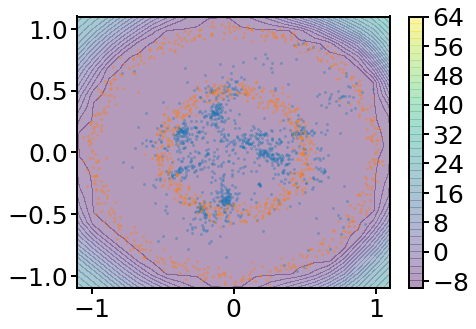

-0.5861983299255371 7.0


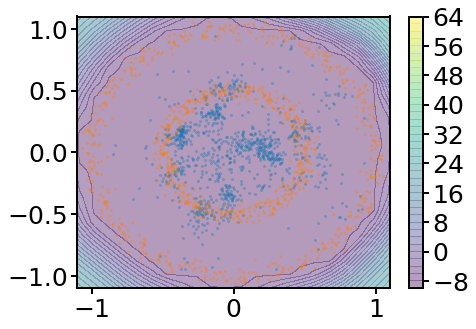

-0.5769195556640625 7.0


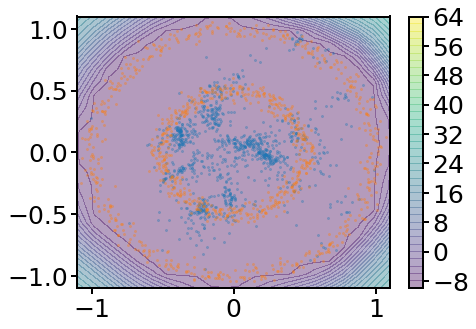

-0.559837818145752 7.0


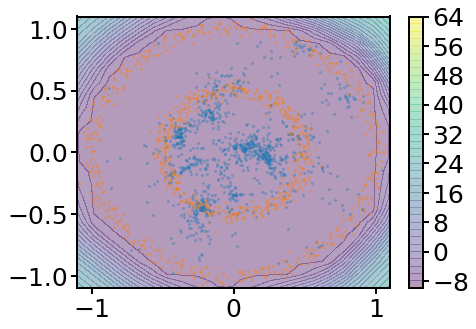

-0.5828852653503418 7.0


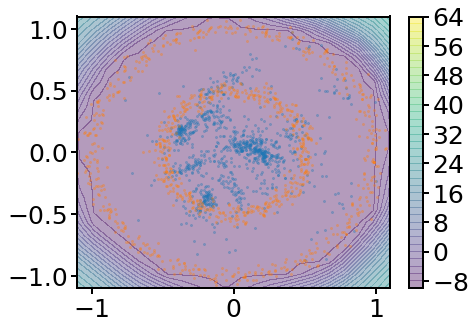

-0.561072826385498 7.0


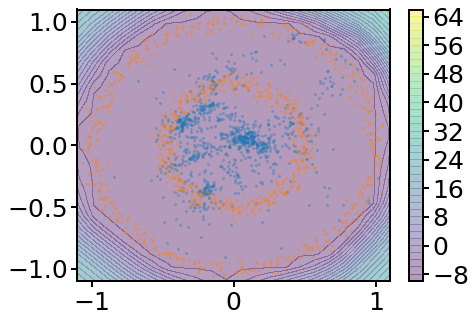

-0.587883472442627 7.0


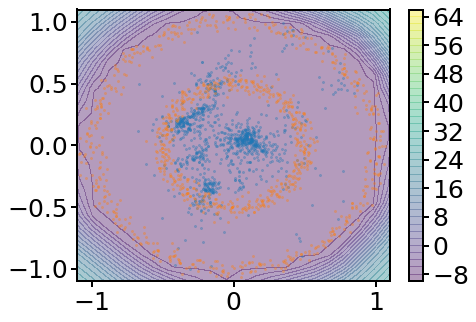

-0.5856499671936035 7.0


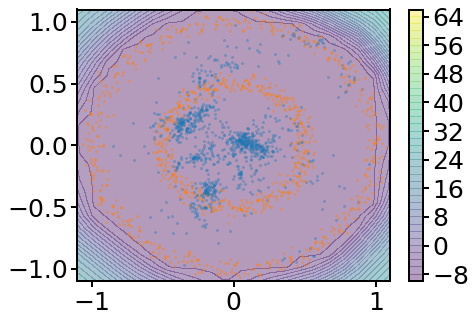

-0.5821986198425293 7.0


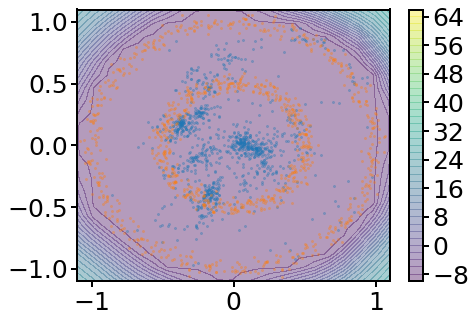

-0.6077203750610352 7.0


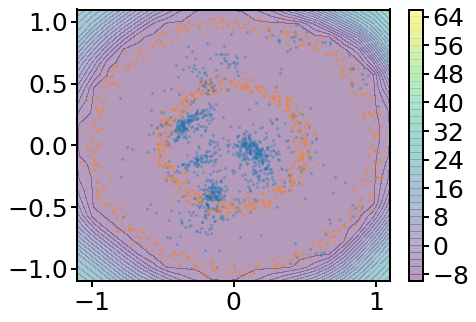

-0.5825648307800293 7.0


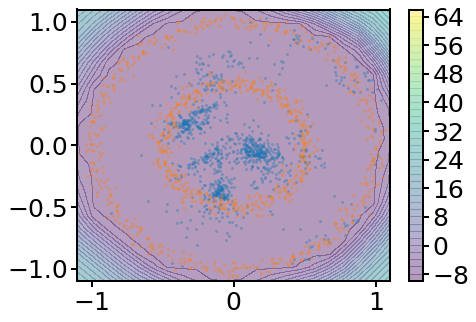

-0.5716977119445801 7.0


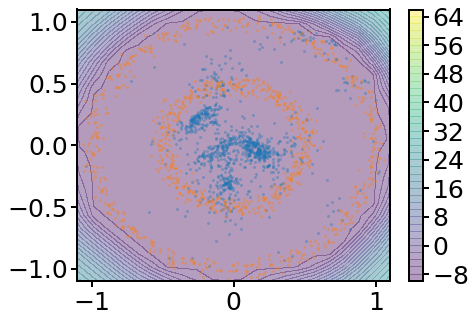

-0.5232467651367188 7.0


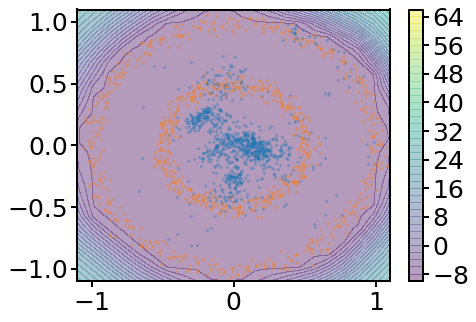

-0.5583782196044922 7.0


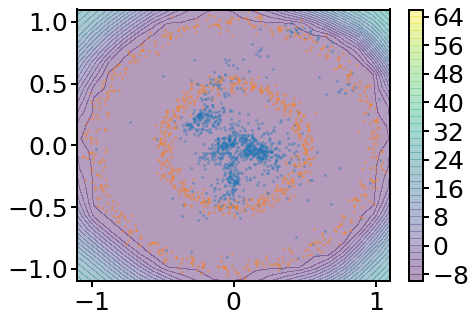

-0.574577808380127 7.0


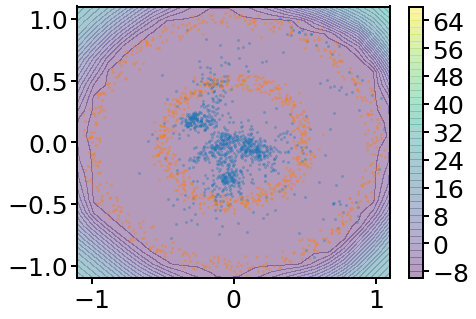

-0.5931062698364258 7.0


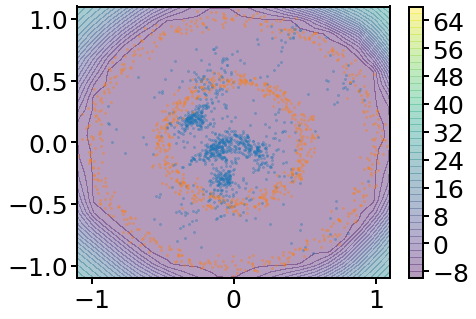

-0.5794038772583008 7.0


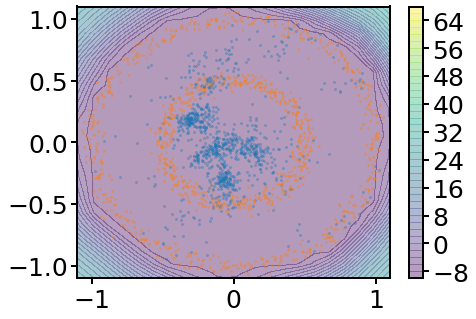

-0.5443601608276367 7.0


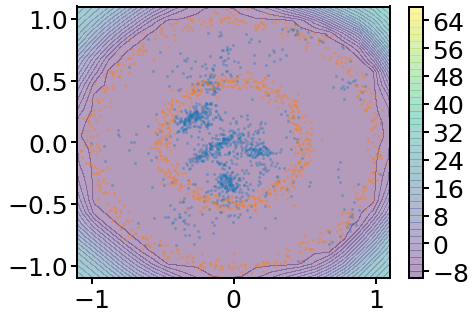

-0.5567684173583984 7.0


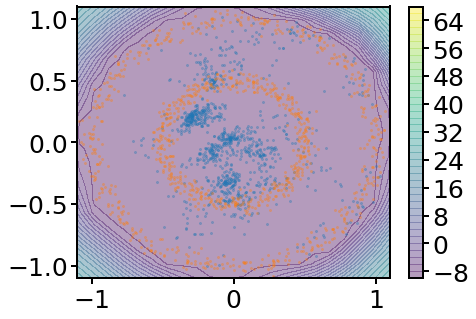

-0.5895309448242188 7.0


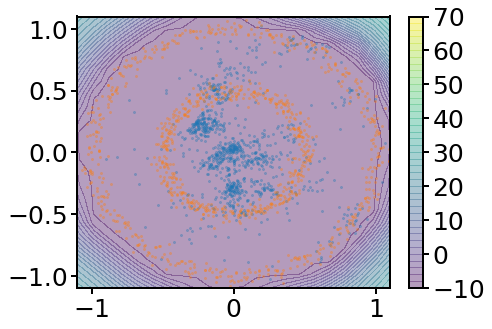

-0.6018562316894531 7.0


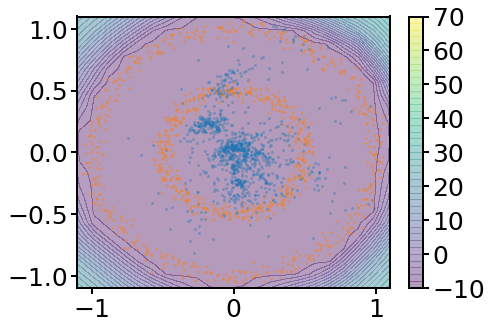

-0.5959510803222656 7.0


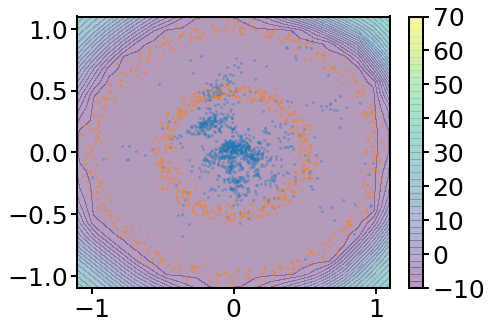

-0.5980954170227051 7.0


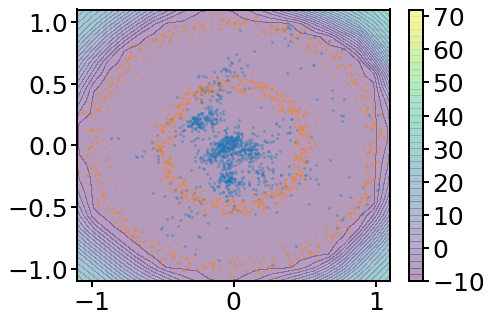

-0.6129188537597656 7.0


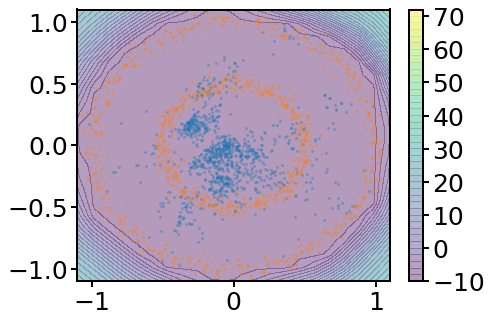

-0.613250732421875 7.0


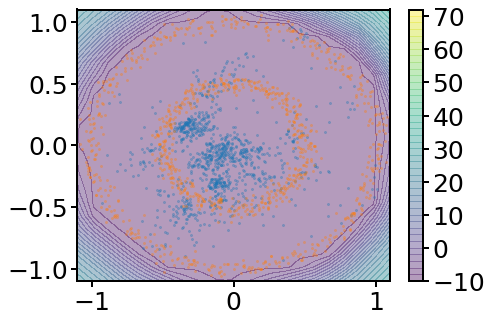

-0.5824241638183594 7.0


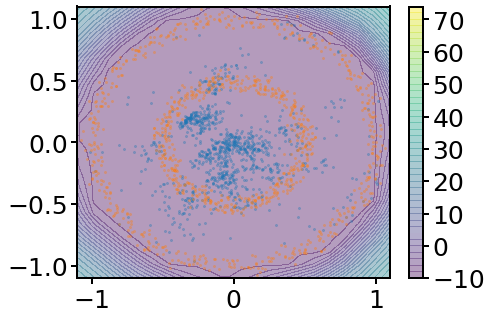

-0.5788407325744629 7.0


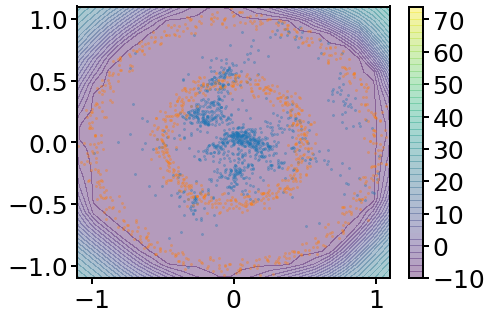

-0.6154060363769531 7.0


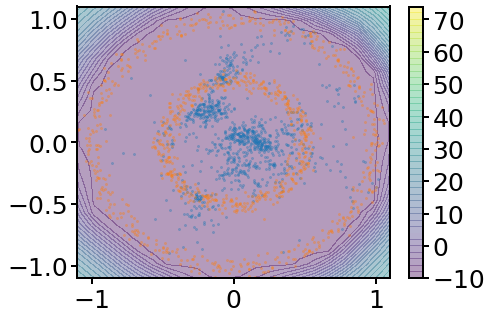

-0.5553750991821289 7.0


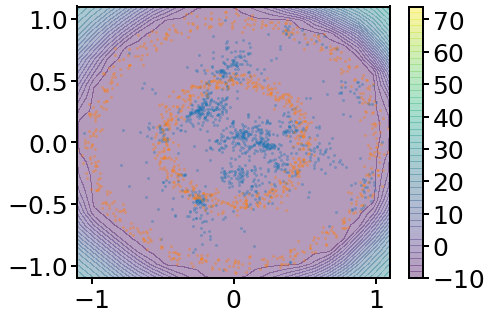

-0.5455684661865234 7.0


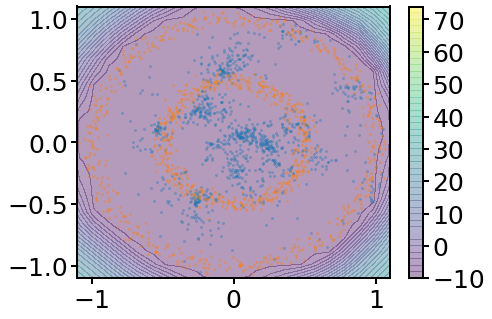

-0.5880393981933594 7.0


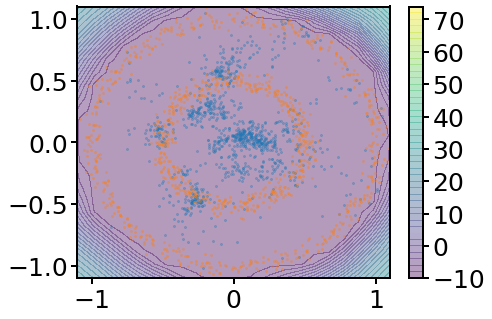

-0.5928106307983398 7.0


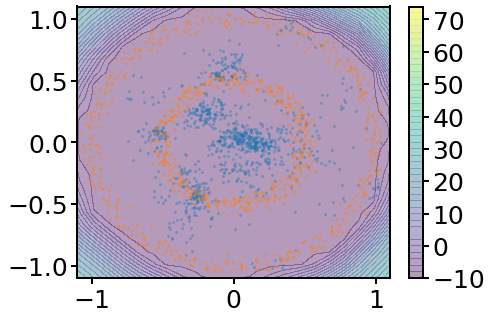

-0.5656356811523438 7.0


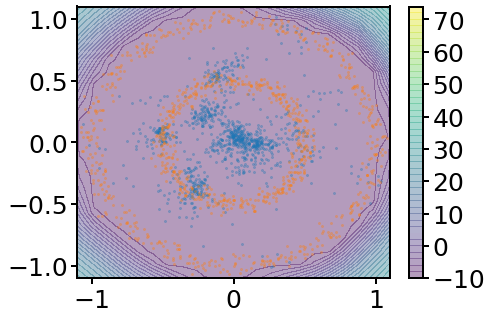

-0.6197357177734375 7.0


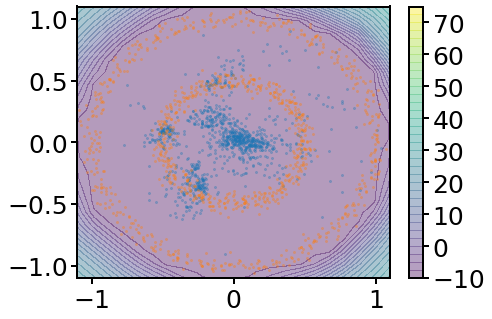

-0.587310791015625 7.0


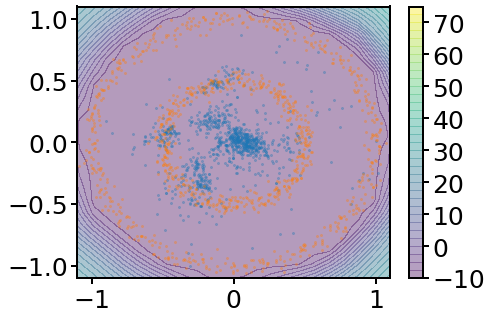

-0.596461296081543 7.0


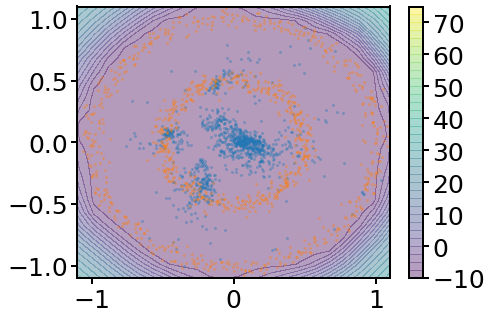

-0.5548095703125 7.0


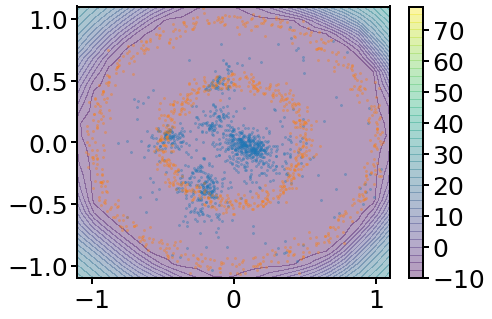

-0.532597541809082 7.0


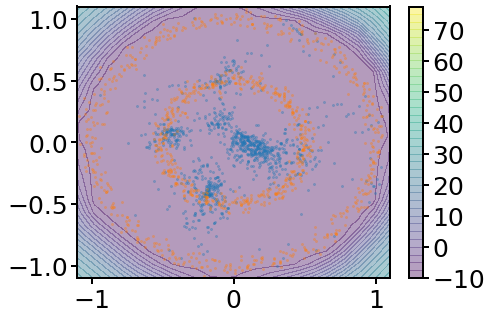

-0.6042299270629883 7.0


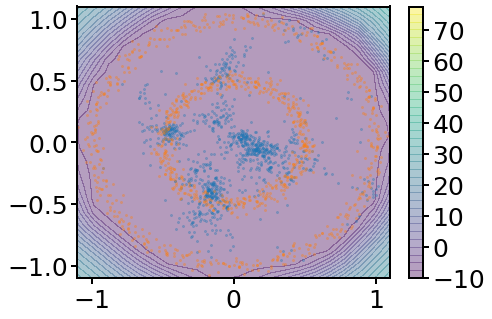

-0.6218929290771484 7.0


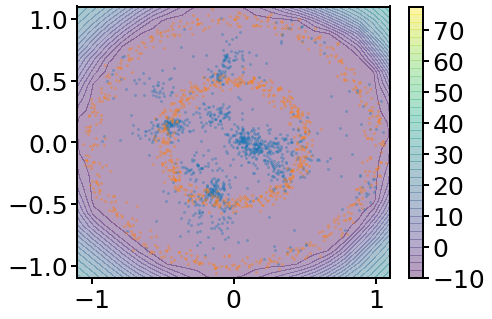

-0.5957498550415039 7.0


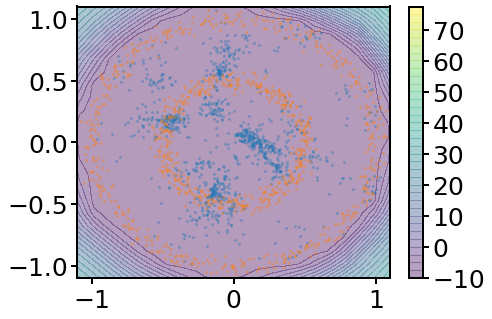

-0.6074352264404297 7.0


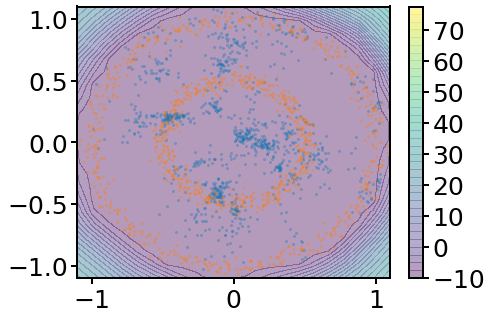

-0.5789480209350586 7.0


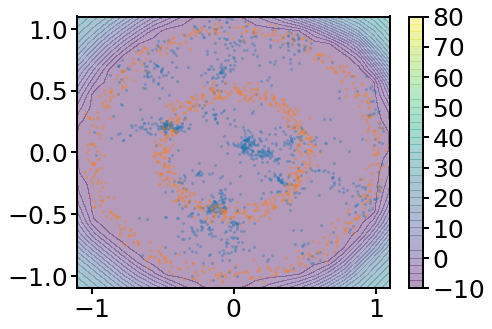

-0.5693063735961914 7.0


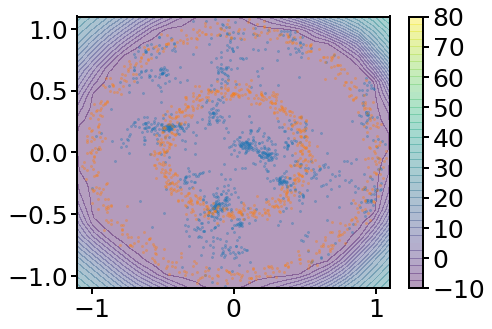

-0.6244621276855469 7.0


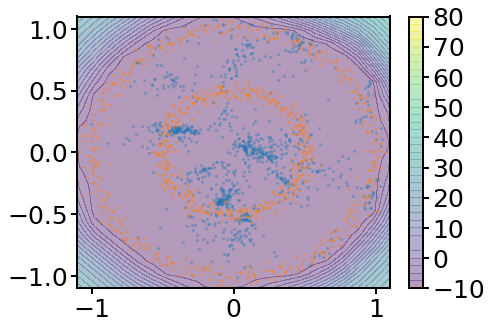

-0.5608310699462891 7.0


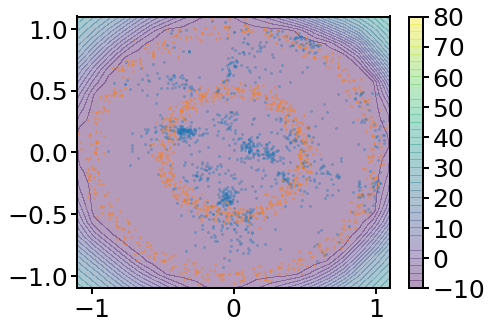

-0.5557851791381836 7.0


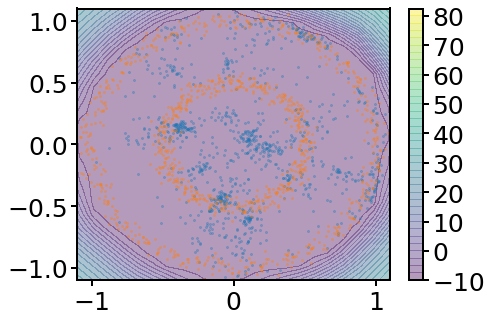

-0.6069498062133789 7.0


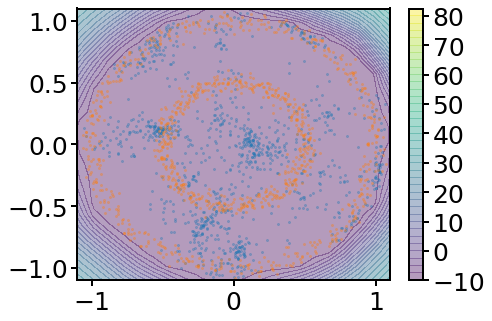

-0.6510896682739258 7.0


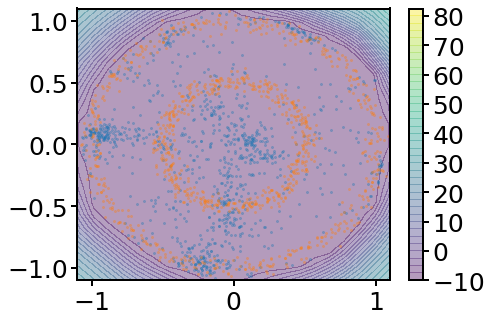

-0.6639242172241211 7.0


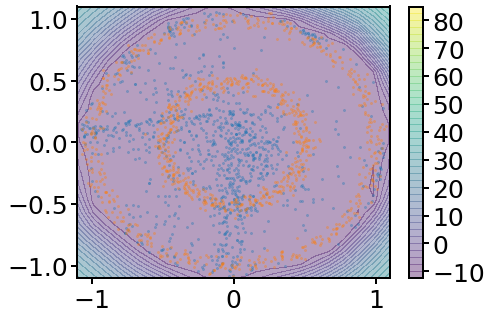

-0.7347116470336914 7.0


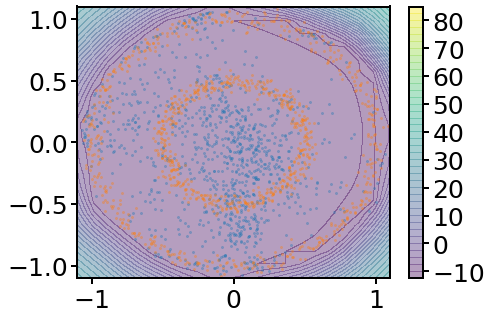

-0.8424892425537109 7.0


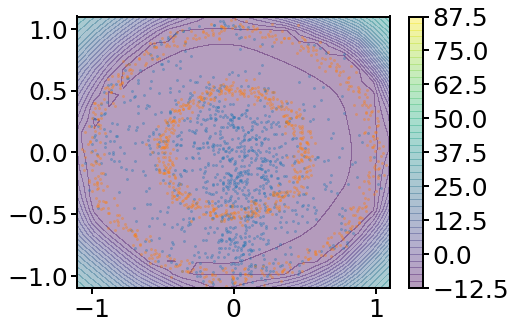

-0.907139778137207 7.0


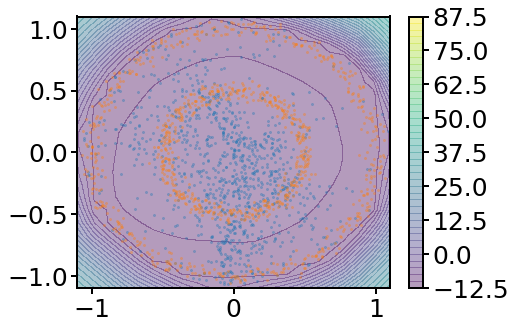

-1.0216684341430664 7.0


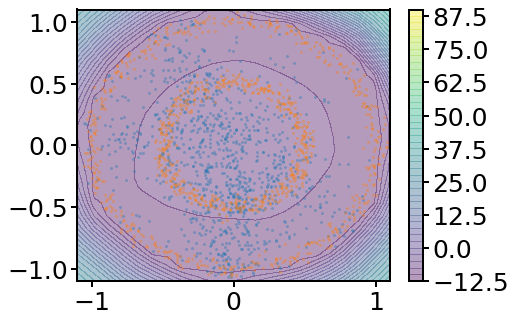

-0.9711360931396484 7.0


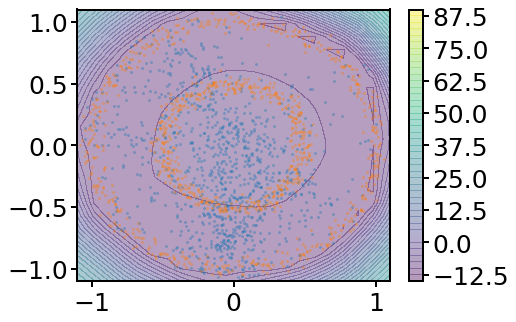

-1.0263519287109375 7.0


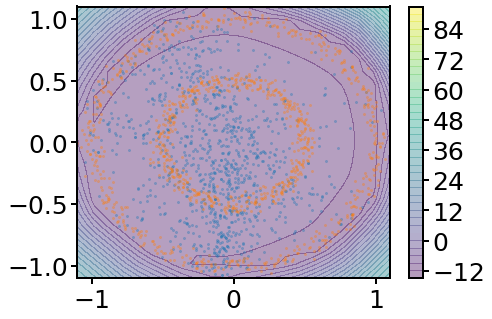

-0.9591856002807617 7.0


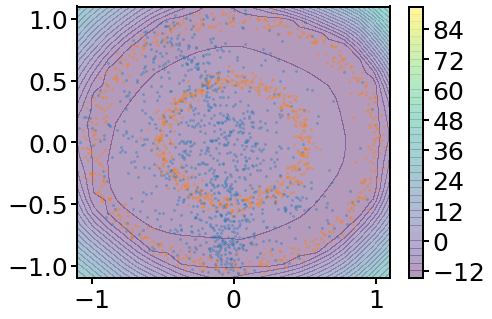

-0.9129428863525391 7.0


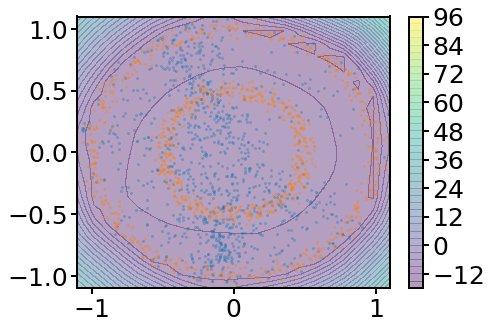

-0.7578926086425781 7.0


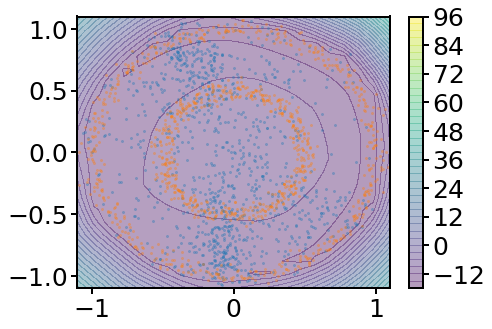

-0.5203113555908203 7.0


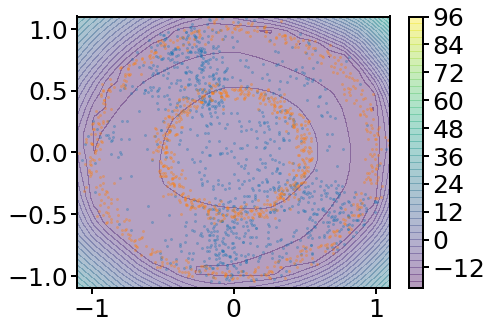

-0.1839761734008789 7.0


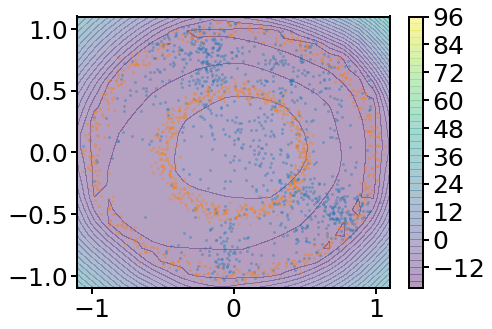

0.4382438659667969 7.0


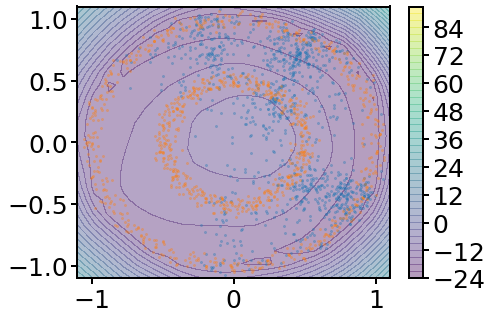

1.3411941528320312 7.0


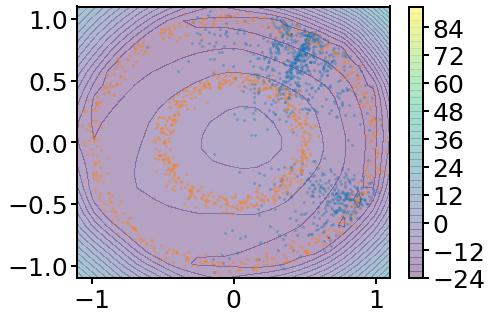

2.498170852661133 7.0


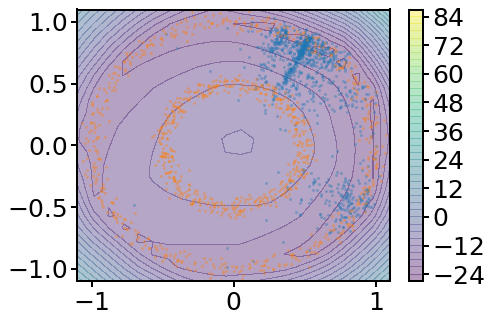

3.7736778259277344 7.0


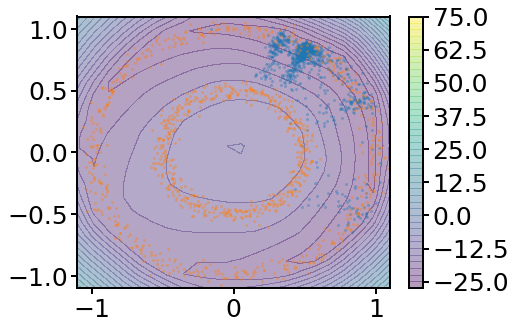

4.869443893432617 7.0


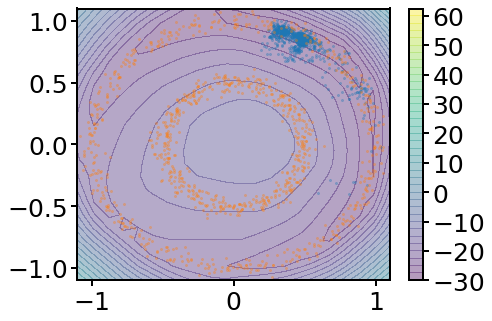

5.911266326904297 7.0


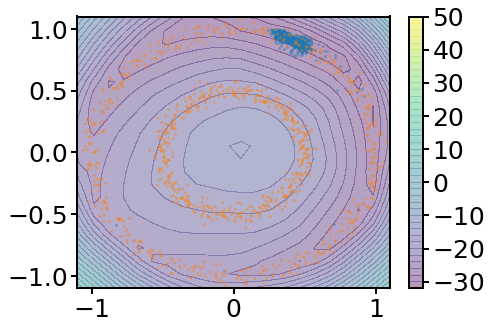

6.687887191772461 7.0


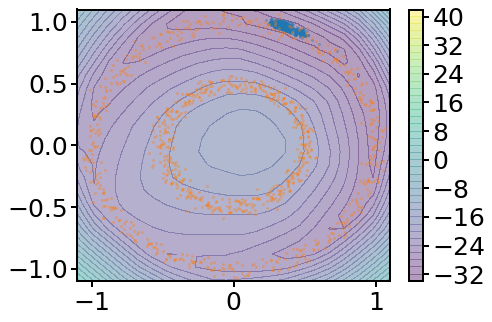

7.393571853637695 7.0


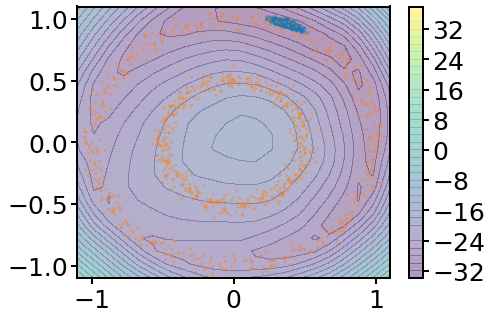

7.033008575439453 7.0


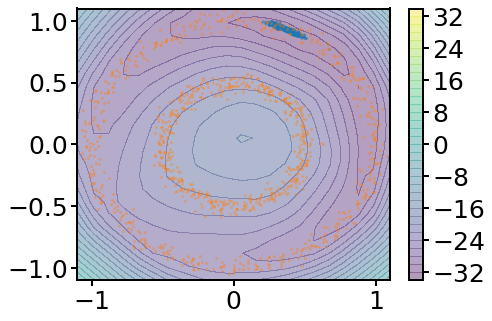

6.253849029541016 7.0


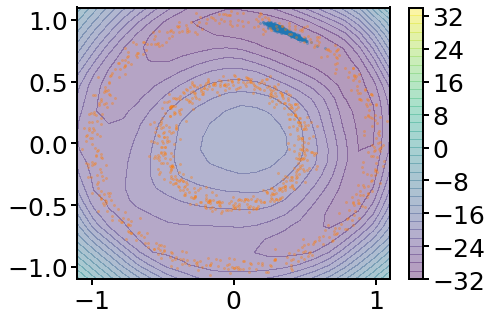

5.301860809326172 7.0


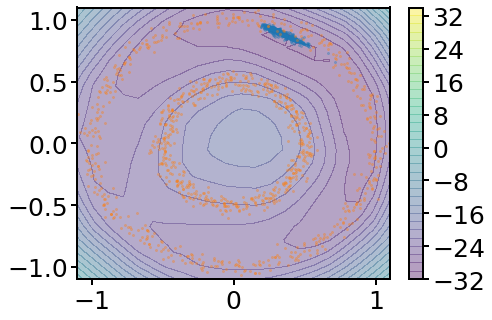

4.133880615234375 7.0


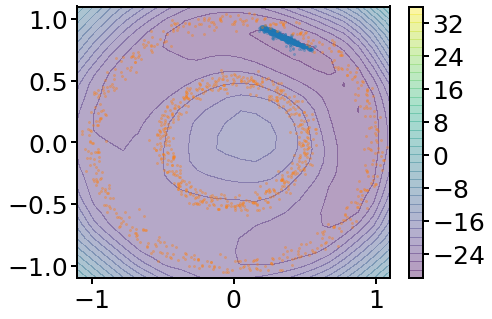

2.8848648071289062 7.0


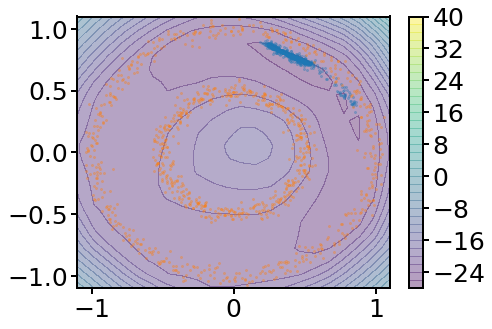

1.770620346069336 7.0


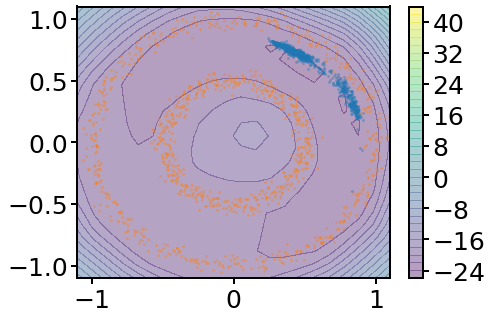

1.0449333190917969 7.0


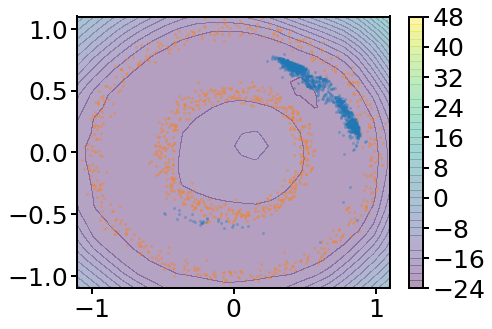

0.2797260284423828 7.0


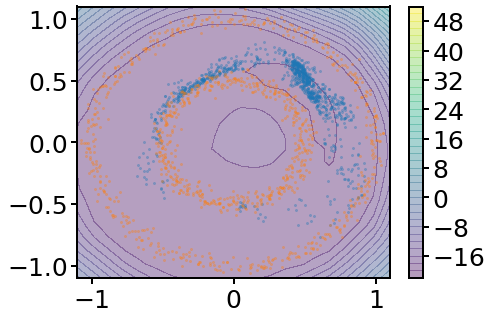

0.14883995056152344 7.0


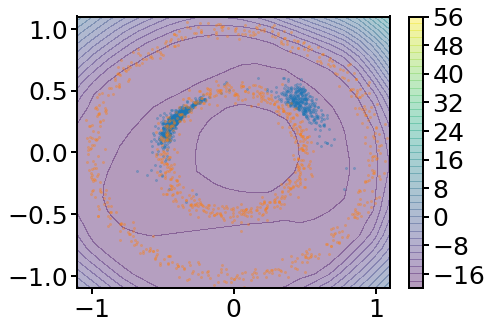

0.32102203369140625 7.0


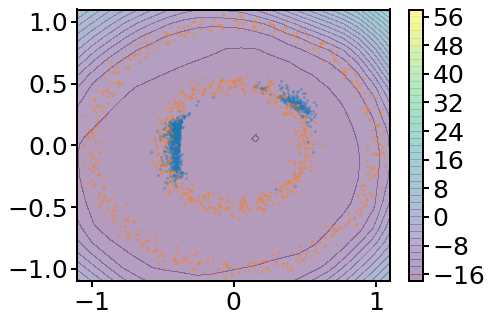

0.5900840759277344 7.0


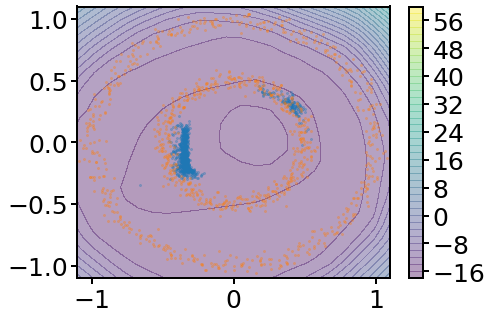

0.8953475952148438 7.0


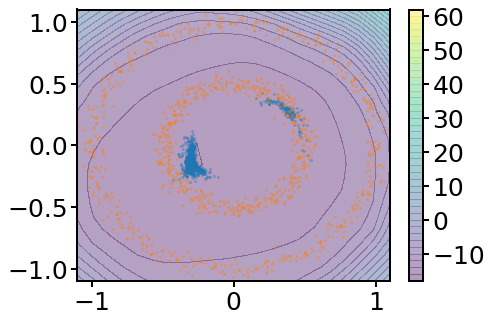

1.1751890182495117 7.0


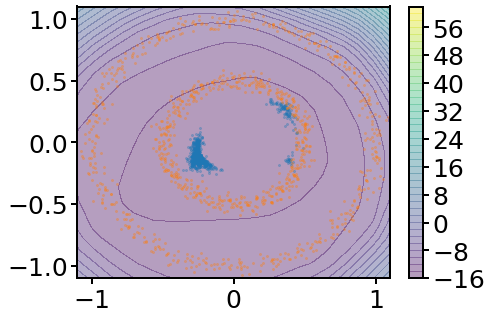

1.3365354537963867 7.0


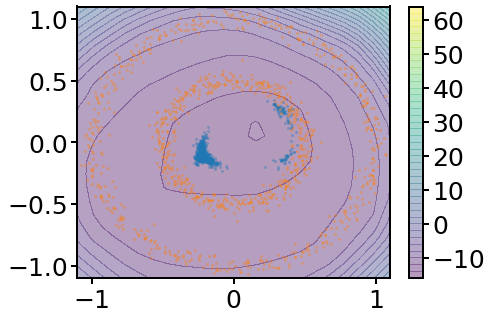

1.5371589660644531 7.0


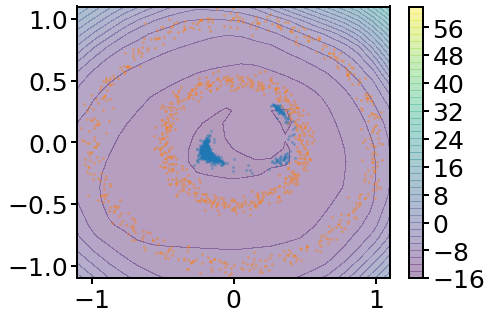

1.6331615447998047 7.0


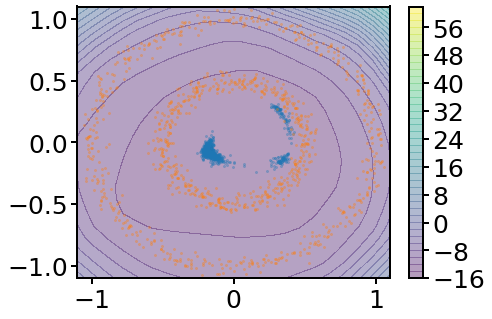

1.670827865600586 7.0


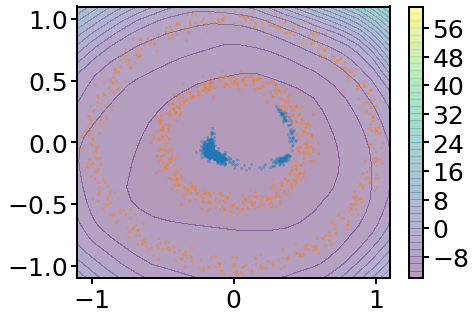

1.6306648254394531 7.0


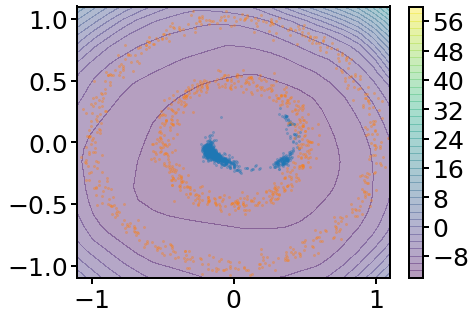

1.563389778137207 7.0


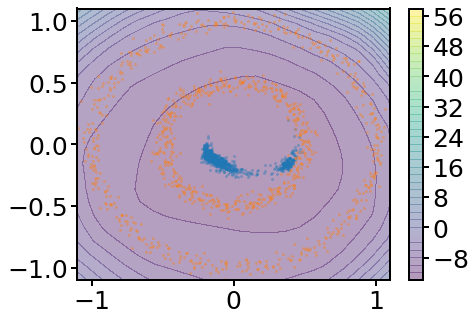

1.4733400344848633 7.0


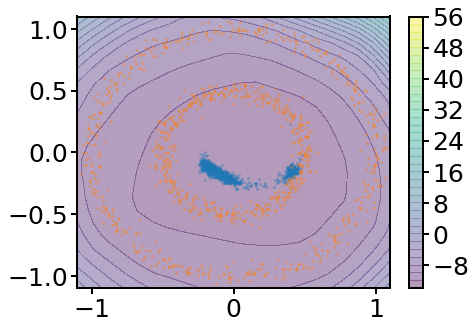

1.342951774597168 7.0


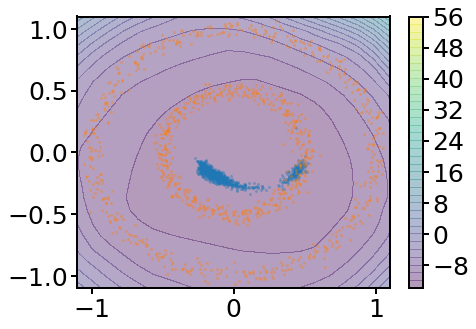

1.1722917556762695 7.0


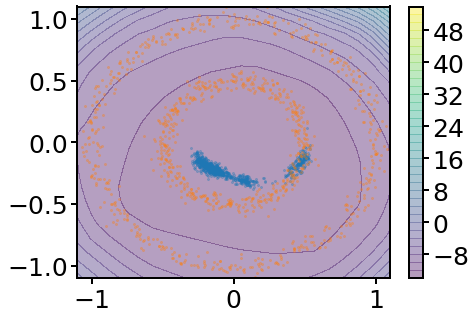

1.020442008972168 7.0


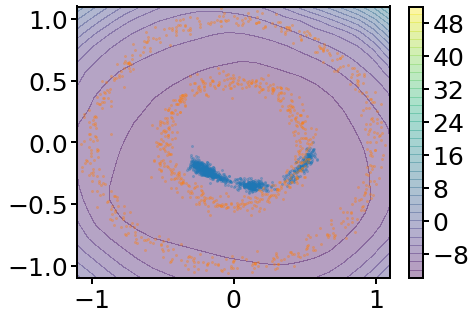

0.8924016952514648 7.0


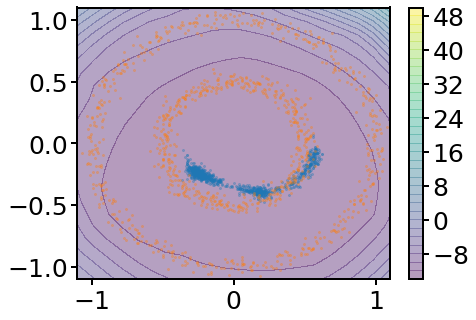

0.7963352203369141 7.0


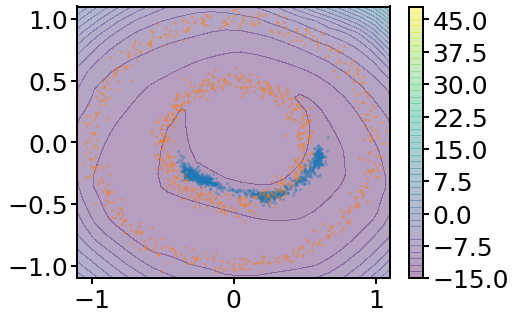

0.6963815689086914 7.0


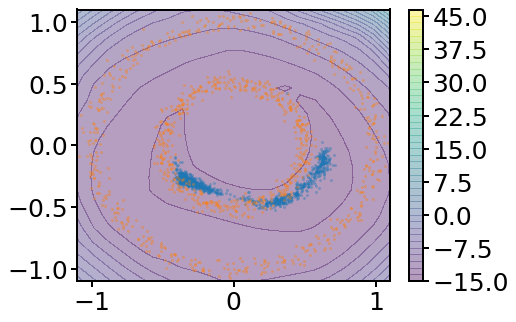

0.5513286590576172 7.0


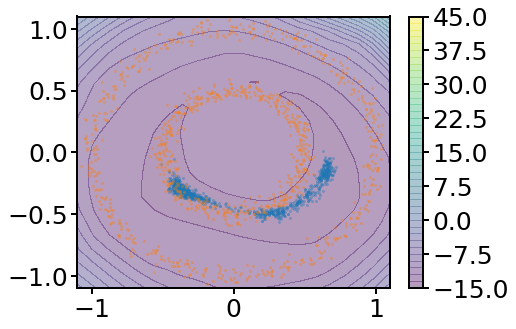

0.5417442321777344 7.0


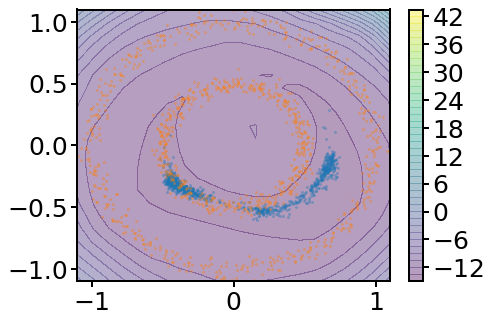

0.45033931732177734 7.0


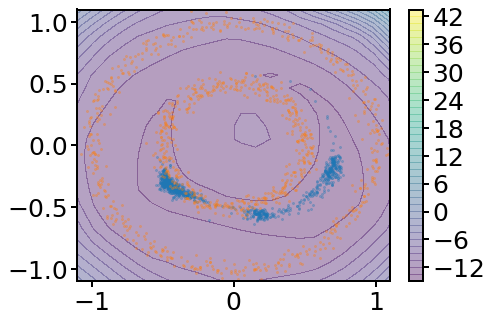

0.4060392379760742 7.0


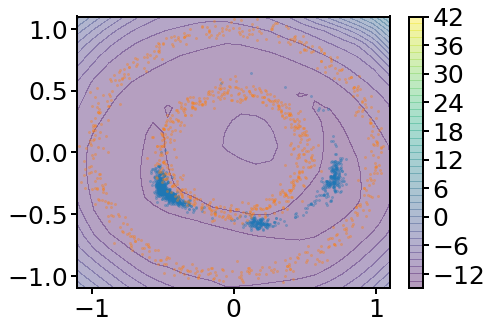

0.35008907318115234 7.0


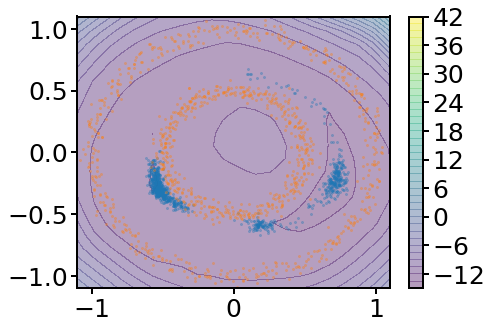

0.3345766067504883 7.0


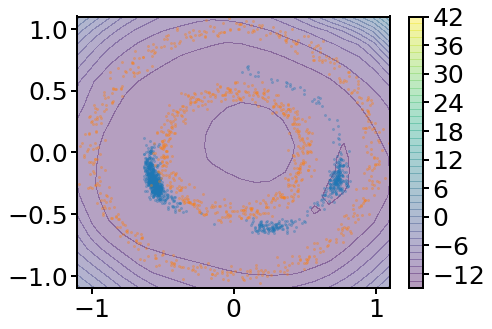

0.32688331604003906 7.0


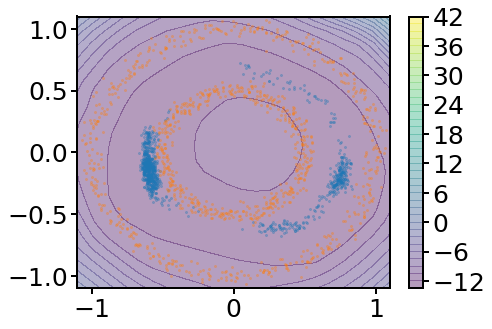

0.30866241455078125 7.0


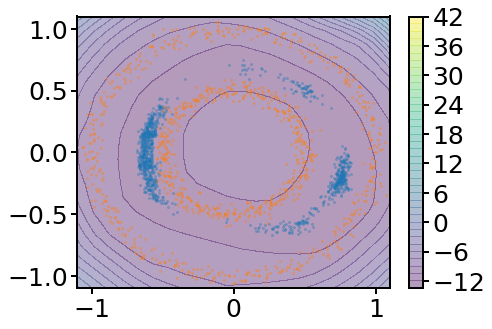

0.36391544342041016 7.0


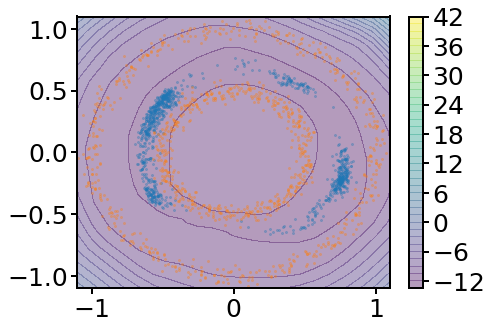

0.34749889373779297 7.0


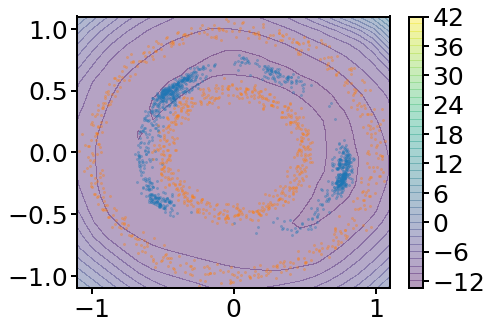

0.3260173797607422 7.0


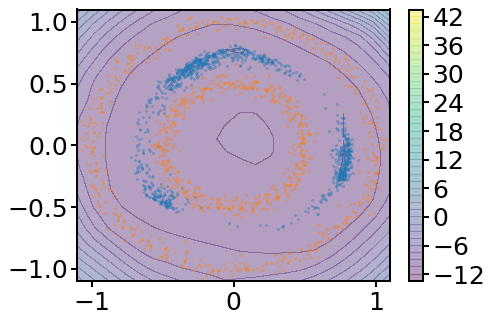

0.35768604278564453 7.0


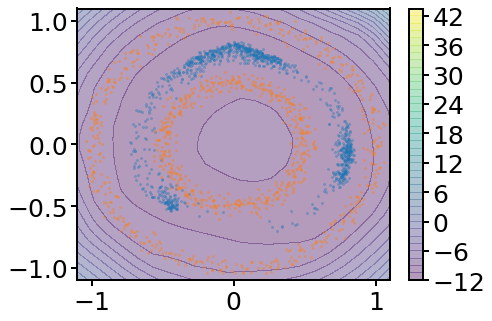

0.3769855499267578 7.0


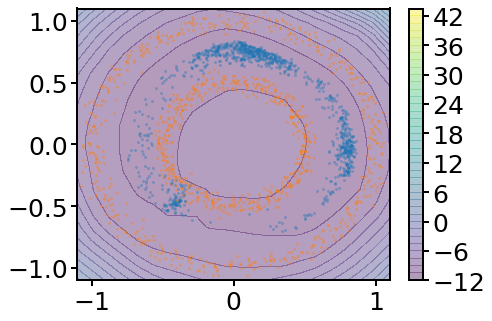

0.35046863555908203 7.0


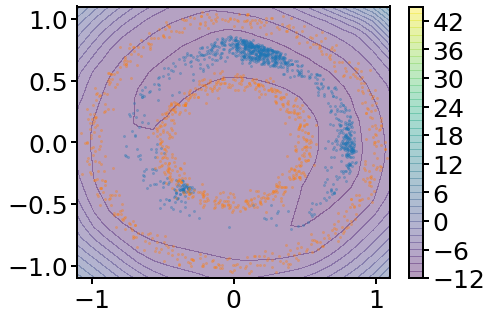

0.2752399444580078 7.0


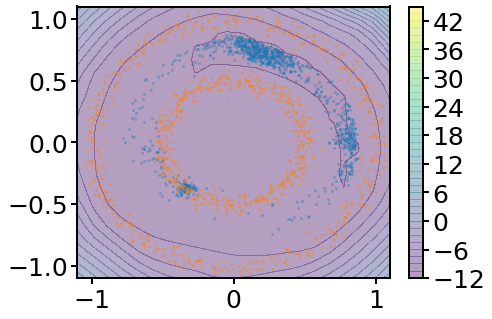

0.29480934143066406 7.0


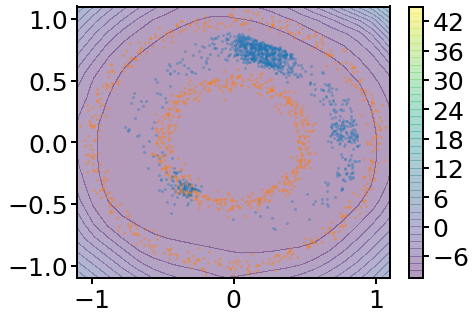

0.24700355529785156 7.0


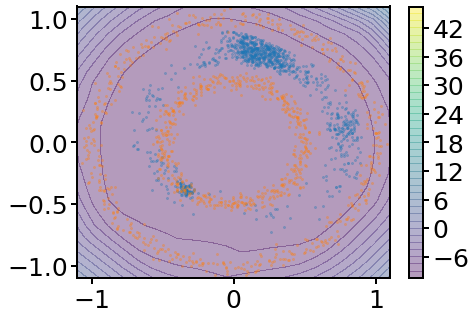

0.18202972412109375 7.0


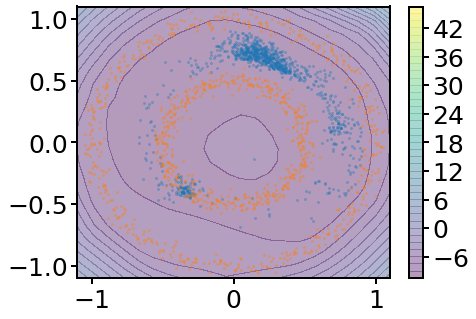

0.08949947357177734 7.0


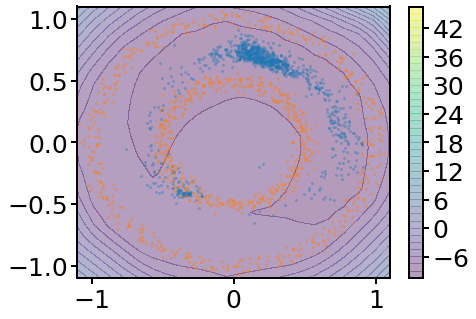

0.04960441589355469 7.0


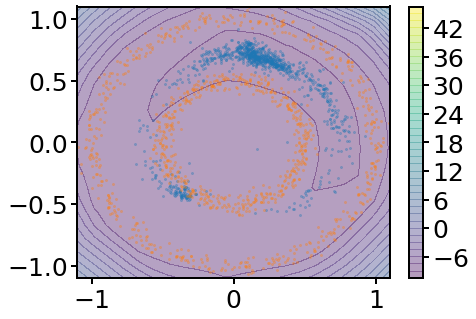

-0.025419235229492188 7.0


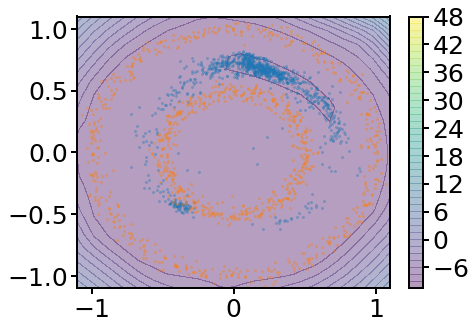

-0.09601116180419922 7.0


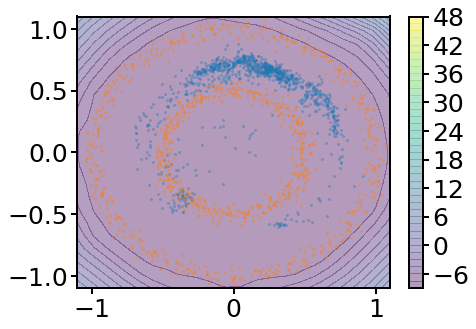

-0.0806741714477539 7.0


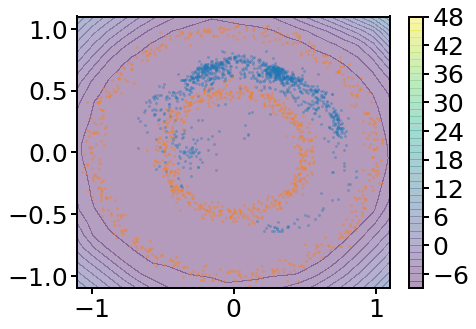

-0.08534622192382812 7.0


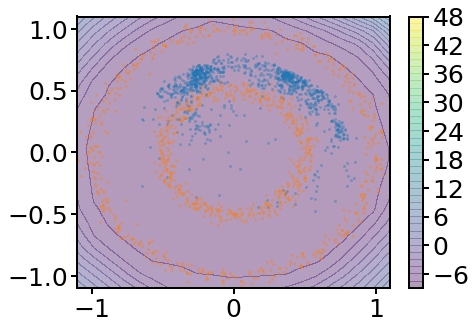

-0.050721168518066406 7.0


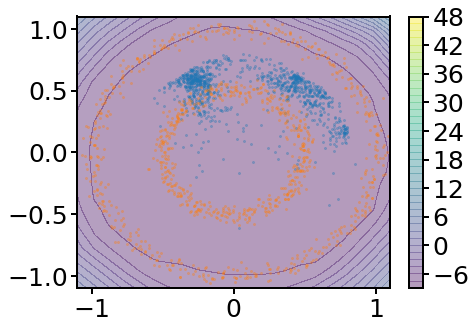

-0.1229405403137207 7.0


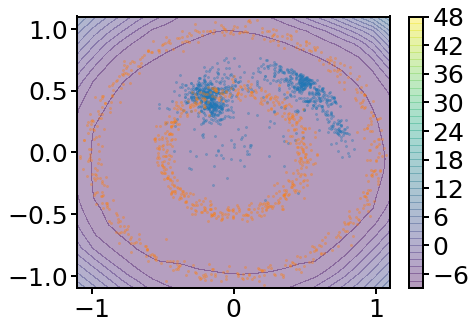

-0.09346437454223633 7.0


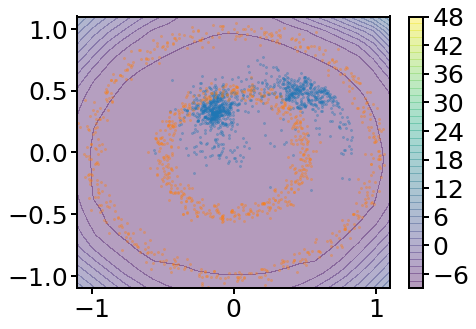

-0.1031045913696289 7.0


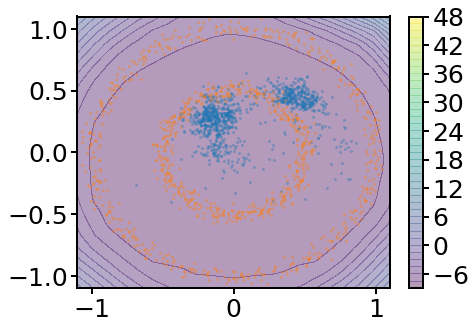

-0.1559767723083496 7.0


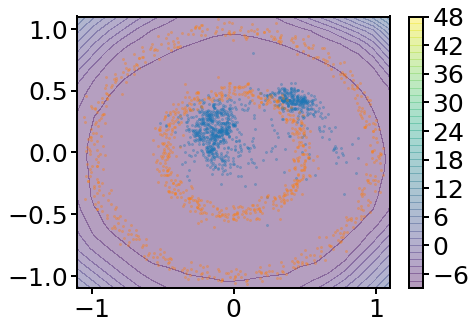

-0.16728830337524414 7.0


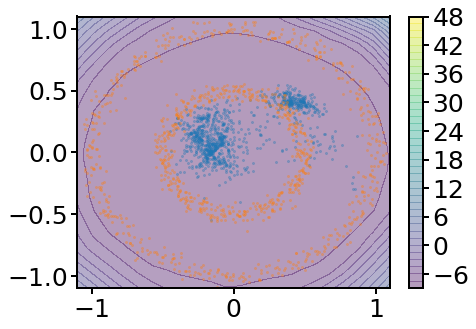

-0.20532894134521484 7.0


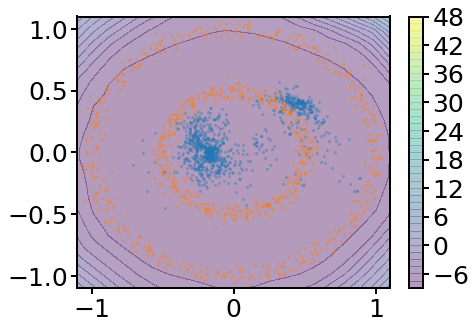

-0.24067974090576172 7.0


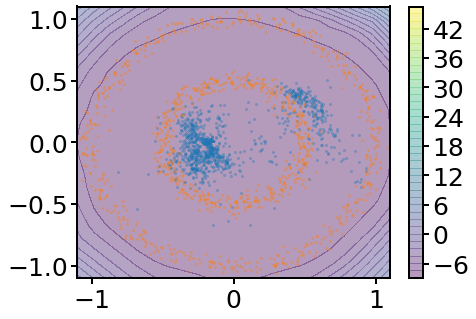

-0.2759737968444824 7.0


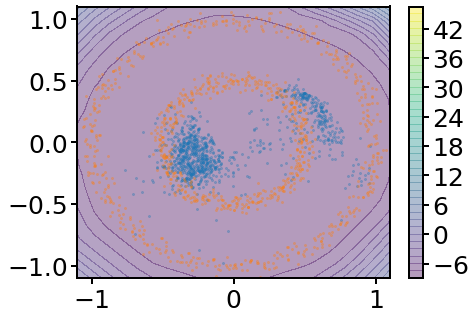

-0.24705743789672852 7.0


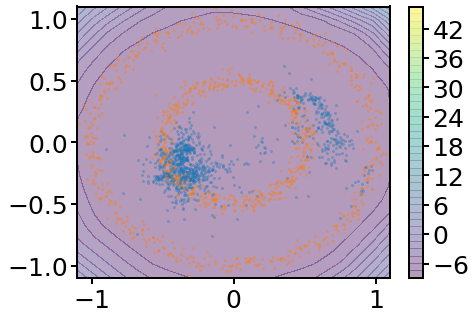

-0.26198244094848633 7.0


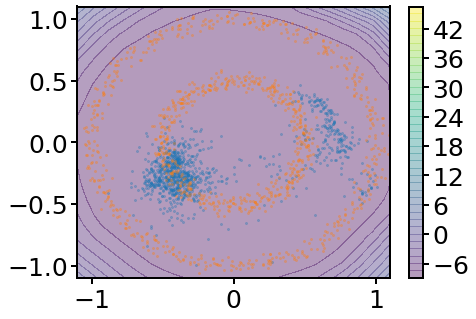

-0.30188417434692383 7.0


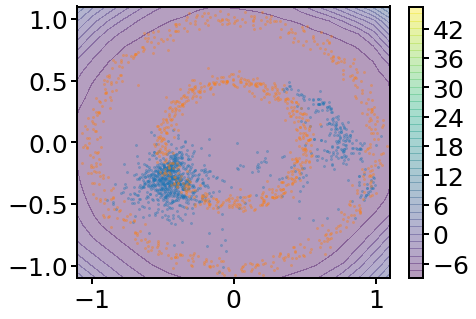

-0.2779550552368164 7.0


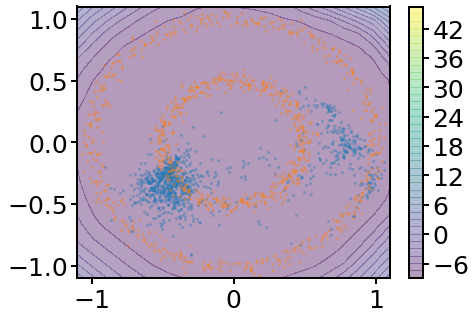

-0.26531171798706055 7.0


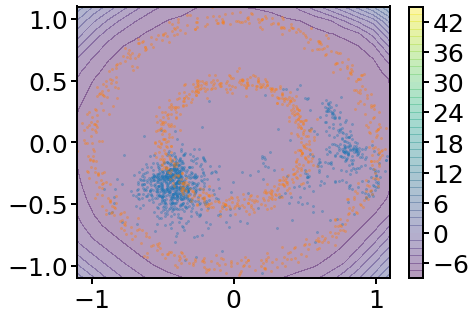

-0.3141751289367676 7.0


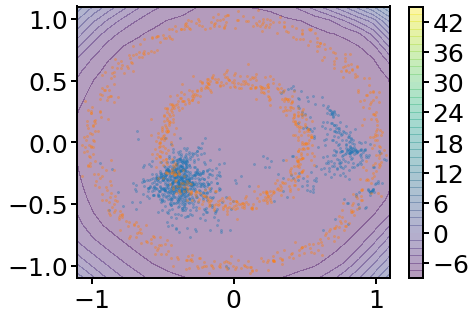

-0.27460813522338867 7.0


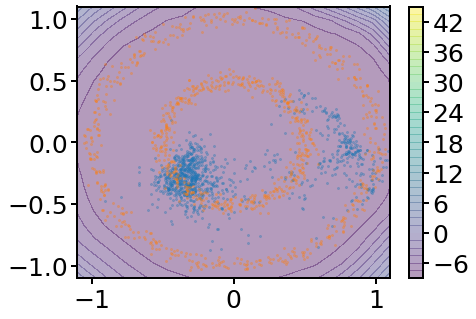

-0.27147626876831055 7.0


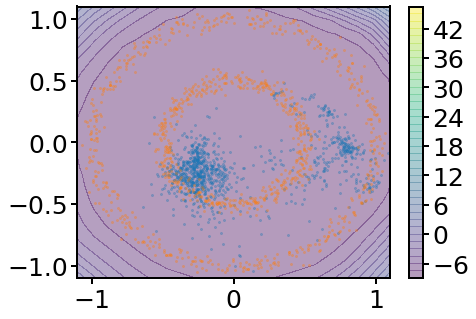

-0.2782325744628906 7.0


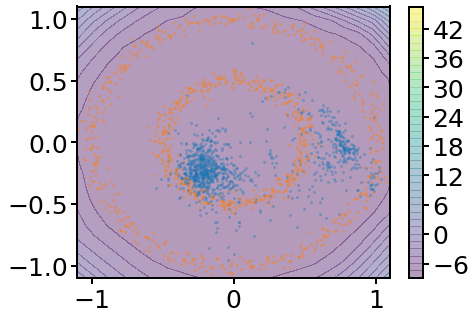

-0.2816181182861328 7.0


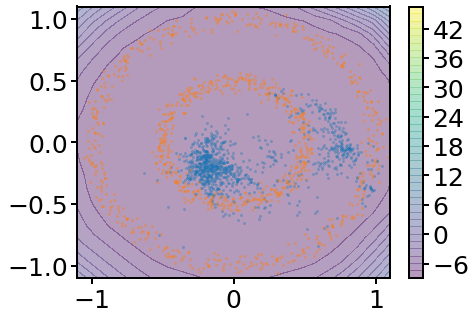

-0.3199453353881836 7.0


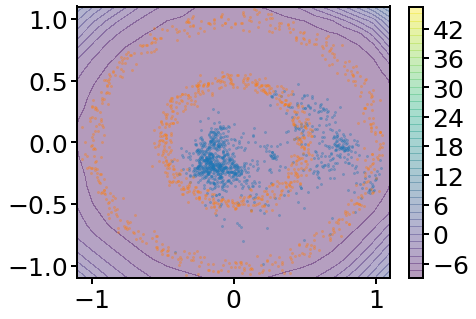

-0.3090825080871582 7.0


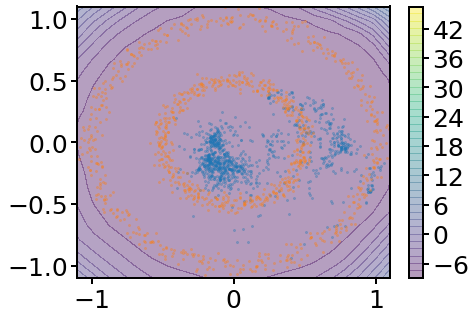

-0.2767333984375 7.0


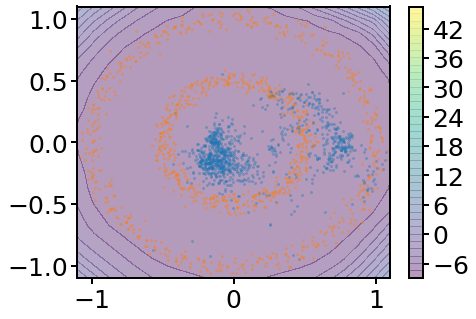

-0.3038444519042969 7.0


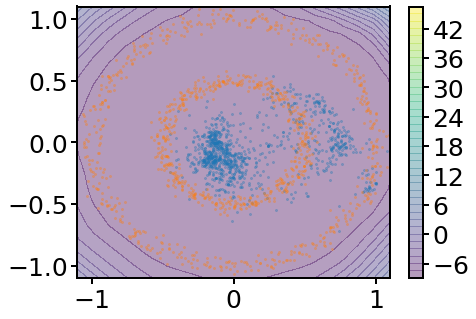

-0.3022799491882324 7.0


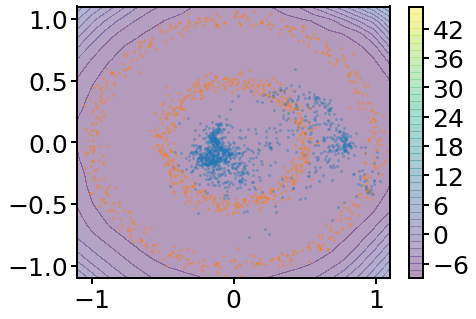

KeyboardInterrupt: 

In [564]:
loss_run = []

for epoch in range(5000):
    
    batch, _= make_circles(n_samples=B, noise=0.04, factor=0.5)
    #batch, _ = make_moons(n_samples=B,
    #              noise=0.09,
    #              random_state=1)
    
    batch = torch.Tensor(batch).to(DEVICE)

    data_nll = h.E(batch)


    # sample from normal distribution and deform 
    p_v = torch.empty(B, 3).normal_(mean=0,std=1)
    q = torch.empty(B, 2).normal_(mean=0,std=1) 
    p = torch.empty(B, 2).normal_(mean=0,std=0.1)
    W = torch.zeros(B, 1).to(DEVICE)
    Q = torch.zeros(B, 1).to(DEVICE)

    pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
    pq.requires_grad= True

    t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
    x, W_traj, Q_traj = odeint(f_x, (pq, W, Q), t, method='rk4')
    
    logZ = -torch.log( torch.exp(-W_traj[-1].reshape(-1)).mean() )

    loss = -logZ + data_nll.mean() + 0.001 * (data_nll - 0.0).pow(2).mean()

    loss.backward()

    loss_run.append([data_nll.mean().item(), -logZ.item()]) 
    
    # lower temperature 
    if f_x.T.item() >= 0.01 and f_x.T.item() <= 2.0:
        T = f_x.T.item()
        f_x.T = torch.Tensor( [T - 0.005] ).to(DEVICE)
        print("T: ", T)
        #scheduler.step()
    optimizer.step()
    optimizer.zero_grad()

    print(np.array(loss_run[-1]).sum(), f_x.model.tau) 

    plot_sep(h.E, x[-1, ::, dim: dim*2].reshape(-1, dim), batch, device=DEVICE)

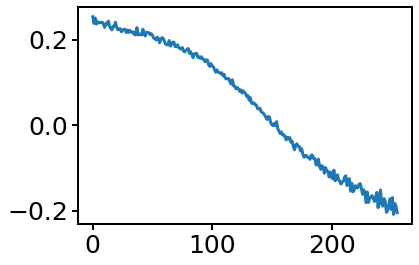

In [491]:
# plot 2d energy 
plt.plot(np.array(loss_run).sum(-1))

In [385]:
x.shape

torch.Size([20, 128, 7])

In [403]:
x[-1, ::1, dim: dim*2].shape

torch.Size([128, 2])

In [404]:
dim

2